#### Image classification many vs many using SVM

In [33]:
### Preparing the Data
import os
from keras.preprocessing import image
from pathlib import Path

## Maintaing the path variable
path = Path("./Datasets")

image_data = []
labels = []

labels_dict = {
    'cats' : 0,
    'dogs' : 1,
    'horses' : 2,
    'humans' : 3
}

for file in os.listdir(path):
    newPath = os.path.join(path,file)
    for img in os.listdir(newPath):
        img_path = os.path.join(newPath,img)
        img_ = image.load_img(img_path,target_size=(32,32))
        img_array = image.img_to_array(img_)
        image_data.append(img_array)
        labels.append(labels_dict[file])

print("The length of the image data list",len(image_data))
print("The length of the labels list",len(labels))

import numpy as np
# Convert this into numpy array
image_data = np.array(image_data,dtype='float32')/255.0
labels = np.array(labels)

print(image_data.shape,labels.shape)

The length of the image data list 808
The length of the labels list 808
(808, 32, 32, 3) (808,)


In [35]:
## Improve acc by shuffling data
import random

combined = list(zip(image_data,labels))
random.shuffle(combined)

#Unzip
image_data[:],labels[:] = zip(*combined)
print(image_data.shape,labels.shape)

(808, 32, 32, 3) (808,)


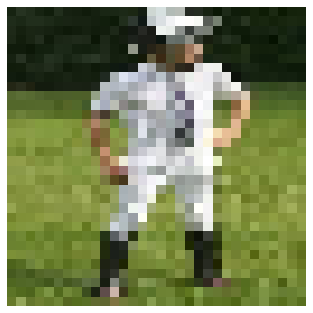

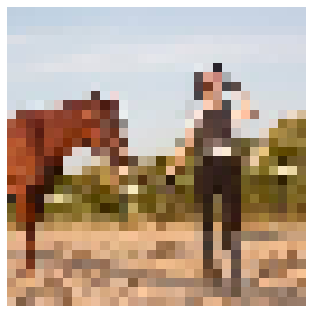

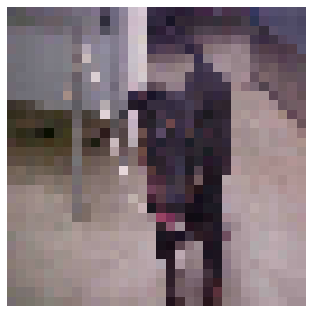

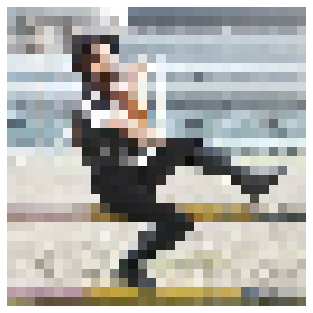

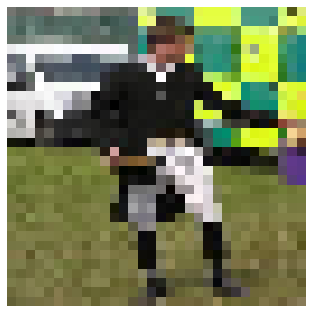

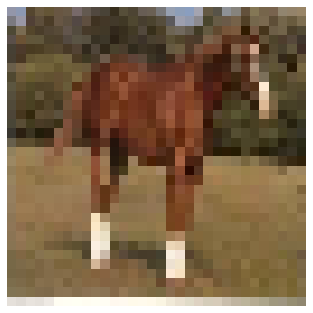

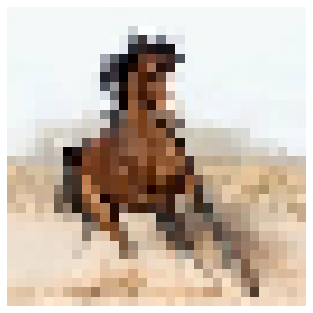

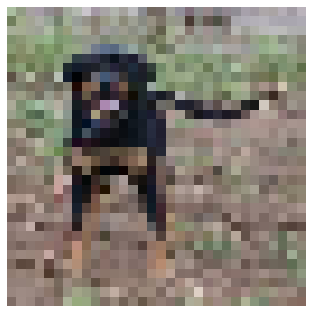

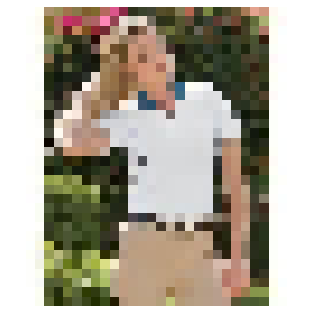

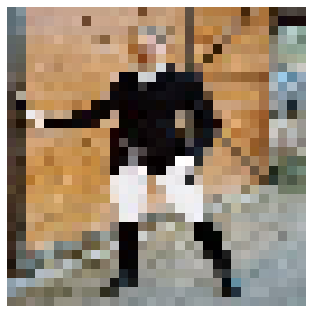

In [41]:
### Visulize the data
import matplotlib.pyplot as plt
def visulizeData(img):
    plt.style.use("seaborn")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

for i in range(10):
    visulizeData(image_data[i])

In [43]:
## Model Preparation
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        
        #Initial Loss
        
        #Training from here...
        # Weight and Bias update rule that we discussed!
        losses = []
        
        for i in range(maxItr):
            #Training Loop
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        
        self.W = W
        self.b = bias
        return W,bias,losses

In [56]:
### Data conversion from 3frame to 1frame
M = image_data.shape[0] 
image_data = image_data.reshape(M,-1)
print(image_data.shape)
print(labels.shape)

CLASSES = np.unique(labels).shape[0]
def classWiseData(x,y):
    data = {}
    
    for i in range(CLASSES):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
    
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data
data = classWiseData(image_data,labels)

def getDataPairForSVM(d1,d2):
    """Combines Data of two classes into a signle matrix"""
    
    l1,l2 = d1.shape[0],d2.shape[0]
    
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = +1
    
    return data_pair,data_labels

(808, 3072)
(808,)


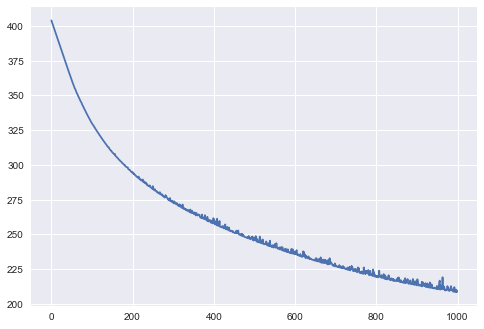

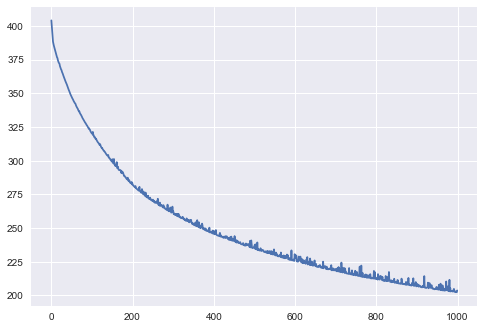

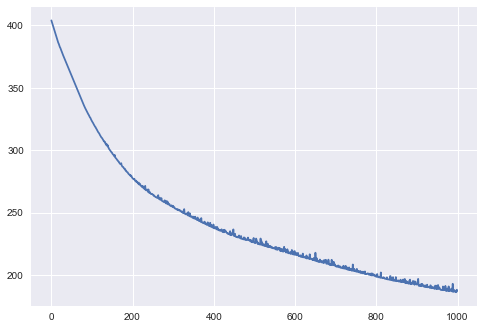

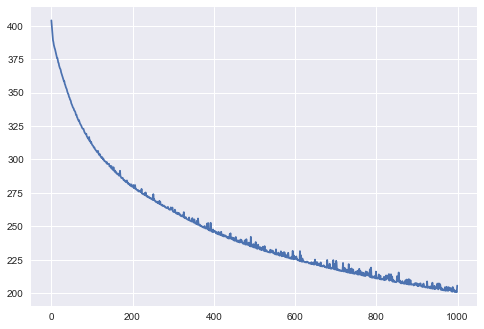

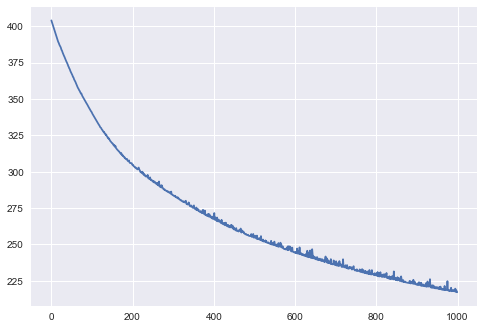

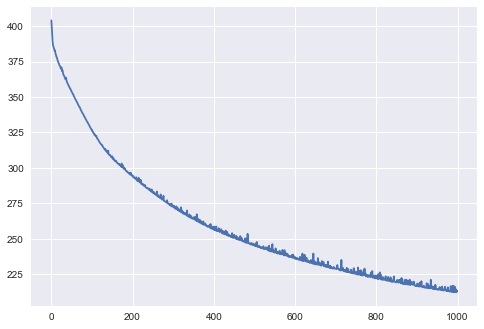

In [60]:
def fitData():
    mySVM  = SVM()
    svm_classifiers = {}
    for i in range(CLASSES):
        svm_classifiers[i] = {}
        for j in range(i+1,CLASSES):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair,ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifiers[i][j] = (wts,b)
            
            plt.plot(loss)
            plt.show()    
    return svm_classifiers

svmClassifierRes = fitData()

In [68]:
def binaryPredict(x,w,b):
    z  = np.dot(x,w.T) + b
    if z>=0:
        return 1
    else:
        return -1

def predict(x):
    count = np.zeros((CLASSES,))
    for i in range(CLASSES):
        for j in range(i+1,CLASSES):
            w,b = svmClassifierRes[i][j]
            #Take a majority prediction 
            z = binaryPredict(x,w,b)
            
            if(z==1):
                count[j] += 1
            else:
                count[i] += 1
    
    final_prediction = np.argmax(count)
    #print(count)
    return final_prediction

def accuracy(x,y):
    count = 0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if(prediction==y[i]):
            count += 1     
    return count/x.shape[0]

accuracy(image_data,labels)

0.5408415841584159

In [70]:
from sklearn import svm
svm_classifier = svm.SVC(kernel='linear',C=1.0)
svm_classifier.fit(image_data,labels)
svm_classifier.score(image_data,labels)

0.5742574257425742